In [1]:
## standart libraries

import os,sys
import numpy as np

import time

# xarray
import xarray as xr
import pandas as pd
import datetime
# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

# for jupyter notebook display
%matplotlib inline

import pkg_resources


In [2]:
# loading one dataset to see all variables in the ice module (40 variables)
prefix = "eORCA025.L75-IMHOTEP"
nexpREF = "GAI"
path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/1y/1980/"+prefix+".GAI_y1980.1y_icemod.nc"
ds = xr.open_dataset(path,decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (y: 1207, x: 1442, time_counter: 1)
Coordinates:
  * time_counter  (time_counter) float64 9.969e+36
Dimensions without coordinates: y, x
Data variables: (12/40)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    simsk         (time_counter, y, x) float32 ...
    simsk15       (time_counter, y, x) float32 ...
    snvolu        (time_counter, y, x) float32 ...
    snthic        (time_counter, y, x) float32 ...
    ...            ...
    albedo        (time_counter, y, x) float32 ...
    hfxcndbot     (time_counter, y, x) float32 ...
    hfxsensib     (time_counter, y, x) float32 ...
    sfxice        (time_counter, y, x) float32 ...
    vfxice        (time_counter, y, x) float32 ...
    vfxsnw        (time_counter, y, x) float32 ...
Attributes:
    start_date:        19580101
    output_frequency:  1m
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.GAI

In [3]:
#ds.sivolu.plot()

# loading data

In [8]:
# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

# read grid files
mesh = xr.open_dataset(diri+'mesh_hgr.nc')
tmask = mesh.tmask[0,0,:,:] # grille lat/lon
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat
e1t = mesh.e1t
e2t = mesh.e2t
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

In [3]:
prefix = "eORCA025.L75-IMHOTEP"
nexp = "S"
nexpAI = "AI"
nexpREF = "GAI"
nexpGA = "GA"
nexpGI = "GI"


varna = 'sivolu' #sivolu

# years to read data from:
y1=1998
y2=2011


fo="1m" # output frequency, could be "1y" or "1m"

#  input directory on store
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridatAI="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpAI+"-S/"
diridatGA="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpGA+"-S/"
diridatGI="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpGI+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

#  input directory on MY work
dirww ="/gpfswork/rech/cli/uor98hu/myncfiles/"

In [5]:
%%time
# creating a dataset with the variable sivolu for the years over period y1-y2

# for a given simu (here S)

# new numpy matrix
# setting the dimensions: x, y t
t_dim = (y2-y1+1)*12
x_dim = 1442
y_dim = 1207
#creating the 3 matrix to obtain
sivolu_matrix = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixREF = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixAI = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixGA = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixGI = np.ones((t_dim, y_dim, x_dim))

time_counter =0
for yr in np.arange(y1,y2+1):
    for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
        filepath = diridat+fo+"/"+str(yr)+"/"+prefix+"."+nexp+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathREF= diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathAI = diridatAI+fo+"/"+str(yr)+"/"+prefix+"."+nexpAI+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathGA = diridatGA+fo+"/"+str(yr)+"/"+prefix+"."+nexpGA+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathGI = diridatGI+fo+"/"+str(yr)+"/"+prefix+"."+nexpGI+"_y"+str(yr)+"m"+month+".1m_icemod.nc"

        #opening the file
        S1y = xr.open_dataset(filepath,decode_times=False)[varna]
        REF1y = xr.open_dataset(filepathREF,decode_times=False)[varna]
        AI1y = xr.open_dataset(filepathAI,decode_times=False)[varna]
        GA1y = xr.open_dataset(filepathGA,decode_times=False)[varna]
        GI1y = xr.open_dataset(filepathGI,decode_times=False)[varna]

        # Saving the yearly data in the new matrix
        sivolu_matrix[time_counter,:,:]   = S1y.isel(time_counter=0).where(ds.nav_lat>0, drop=False).values 
        sivolu_matrixREF[time_counter,:,:]= REF1y.isel(time_counter=0).where(ds.nav_lat>0, drop=False).values
        sivolu_matrixAI[time_counter,:,:] = AI1y.isel(time_counter=0).where(ds.nav_lat>0, drop=False).values
        sivolu_matrixGA[time_counter,:,:] = GA1y.isel(time_counter=0).where(ds.nav_lat>0, drop=False).values
        sivolu_matrixGI[time_counter,:,:] = GI1y.isel(time_counter=0).where(ds.nav_lat>0, drop=False).values

        time_counter+=1
    print(yr)

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
CPU times: user 43.5 s, sys: 14.3 s, total: 57.9 s
Wall time: 3min 11s


In [6]:
60*60*24*365

31536000

# converting the matrixes into datarray easy to use

In [6]:
time = pd.date_range(start=str(y1), end=str(y2+1), freq='M')
np.shape(time)

(168,)

In [7]:
%%time
#creating the coordinates for the datarray
time = pd.date_range(start=str(y1), end=str(y2+1), freq='M')
lats = ds.nav_lat.values
longs = ds.nav_lon.values

dasivolu = xr.DataArray(data=sivolu_matrix, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluREF = xr.DataArray(data=sivolu_matrixREF, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluAI = xr.DataArray(data=sivolu_matrixAI, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluGA = xr.DataArray(data=sivolu_matrixGA, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluGI = xr.DataArray(data=sivolu_matrixGI, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

CPU times: user 0 ns, sys: 6.14 ms, total: 6.14 ms
Wall time: 26.5 ms


In [9]:
#dasivolu

### converting to ice VOLUME

In [9]:
#surface of each cell
cellArea = e1t.isel(time_counter=0)*e2t.isel(time_counter=0) 

# calculating the volume for each mixel
dasiVOlu = dasivolu*cellArea
dasiVOluREF = dasivoluREF*cellArea
dasiVOluAI = dasivoluAI*cellArea
dasiVOluGA = dasivoluGA*cellArea
dasiVOluGI = dasivoluGI*cellArea

# selecting the Arctic only
Arctic_dasiVOlu = dasiVOlu.where(dasiVOlu.lat>0, drop=False)
Arctic_dasiVOluREF = dasiVOluREF.where(dasiVOluREF.lat>0, drop=False)
Arctic_dasiVOluAI = dasiVOluAI.where(dasiVOluAI.lat>0, drop=False)
Arctic_dasiVOluGA = dasiVOluGA.where(dasiVOluGA.lat>0, drop=False)
Arctic_dasiVOluGI = dasiVOluGI.where(dasiVOluGI.lat>0, drop=False)

In [10]:
#calculating the total volume
Tot_Arctic_dasiVOlu = Arctic_dasiVOlu.sum(('x','y'))
Tot_Arctic_dasiVOluREF = Arctic_dasiVOluREF.sum(('x','y'))
Tot_Arctic_dasiVOluAI = Arctic_dasiVOluAI.sum(('x','y'))
Tot_Arctic_dasiVOluGA = Arctic_dasiVOluGA.sum(('x','y'))
Tot_Arctic_dasiVOluGI = Arctic_dasiVOluGI.sum(('x','y'))

In [39]:
#calculating the yearly mean 
timeyear = pd.date_range(start=str(y1), end=str(y2+1), freq='Y')
timeyear = timeyear - pd.DateOffset(months=6)

Tot_Arctic_dasiVOluyrmean    = Tot_Arctic_dasiVOlu.groupby('time_counter.year').mean()
Tot_Arctic_dasiVOluyrmeanREF = Tot_Arctic_dasiVOluREF.groupby('time_counter.year').mean()
Tot_Arctic_dasiVOluAIyrmeanAI= Tot_Arctic_dasiVOluAI.groupby('time_counter.year').mean()


In [47]:
Tot_Arctic_dasiVOluyrmeanREF/1e12

<xarray.DataArray (year: 14)>
array([19.44088004, 19.47384807, 19.67135586, 20.03757077, 18.95836668,
       18.54015548, 18.57654896, 18.58787238, 17.83698281, 16.74928434,
       16.93487396, 17.19891148, 16.67851529, 15.98149518])
Coordinates:
  * year     (year) int64 1998 1999 2000 2001 2002 ... 2007 2008 2009 2010 2011

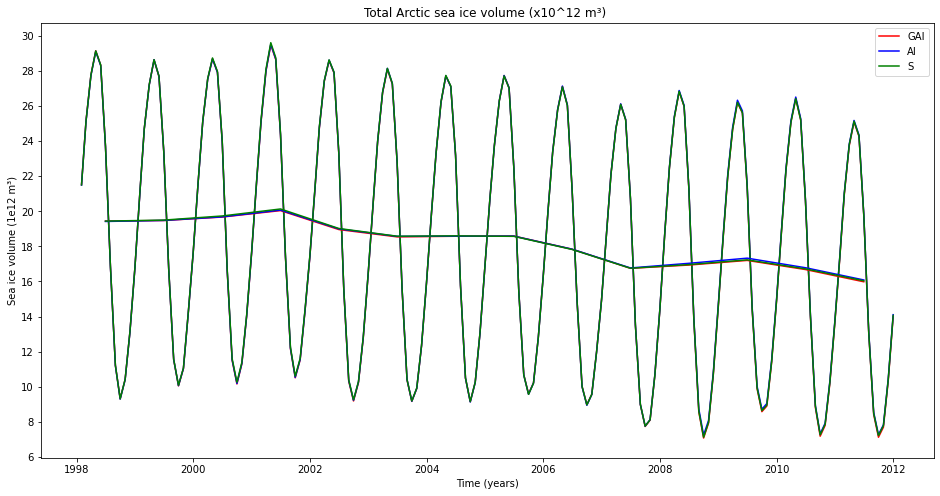

from monthly data


In [46]:
# time series of totla Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,8]),facecolor='white')
plt.plot(time,Tot_Arctic_dasiVOluREF/1e12,color='r')
plt.plot(time,Tot_Arctic_dasiVOluAI/1e12,color='b')
plt.plot(time,Tot_Arctic_dasiVOlu/1e12, color='g')

#plt.plot(time,Tot_Arctic_dasiVOluGA/1e12)
#plt.plot(time,Tot_Arctic_dasiVOluGI/1e12)
plt.plot(timeyear,Tot_Arctic_dasiVOluyrmeanREF/1e12,color='r')
plt.plot(timeyear,Tot_Arctic_dasiVOluAIyrmeanAI/1e12,color='b')
plt.plot(timeyear,Tot_Arctic_dasiVOluyrmean/1e12,color='g')

plt.yticks(np.arange(6, 31, 2))

plt.legend(['GAI','AI','S'])
plt.title('Total Arctic sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from monthly data")

In [25]:
(Tot_Arctic_dasiVOluAI/1e12).mean()

<xarray.DataArray ()>
array(17.67406491)

In [23]:
print((Tot_Arctic_dasiVOluREF/1e12).mean().values, "10³ km³")

17.636627663470644 10³ km³


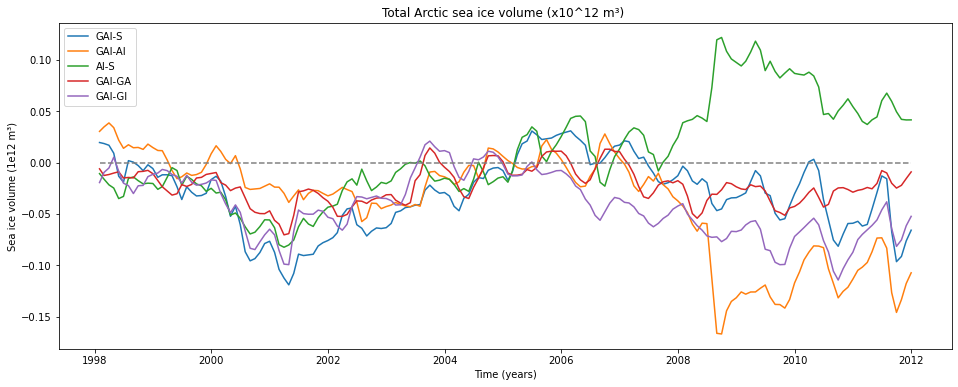

from monthly data


In [50]:
# time series of totla Arctic sea ice volume for the three simulations
GAI_S = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOlu/1e12
GAI_AI = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOluAI/1e12
AI_S = Tot_Arctic_dasiVOluAI/1e12 - Tot_Arctic_dasiVOlu/1e12
GAI_GA = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOluGA/1e12
GAI_GI = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOluGI/1e12


plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,GAI_S)
plt.plot(time,GAI_AI)
plt.plot(time,AI_S)
plt.plot(time,GAI_GA)
plt.plot(time,GAI_GI)

plt.plot(time,np.zeros(168),linestyle='--', color='grey')

# test de vérification de la linéarité
#somme = GAI_AI + AI_S
#plt.plot(time,somme)

#plt.plot(time,np.tile(BGsiVOlu_clim/1e11,14))
plt.legend(['GAI-S','GAI-AI','AI-S','GAI-GA','GAI-GI'])
plt.title('Total Arctic sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from monthly data")

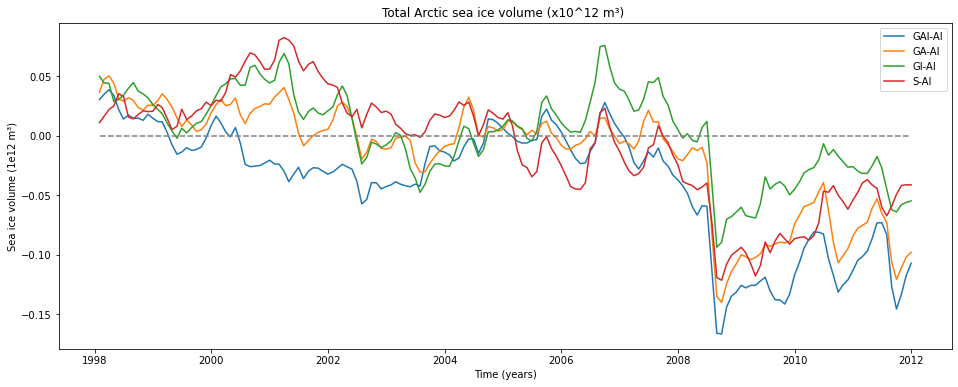

from monthly data


In [11]:
# time series of totla Arctic sea ice volume for the three simulations
#GAI_S = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOlu/1e12
GAI_AI = Tot_Arctic_dasiVOluREF/1e12 - Tot_Arctic_dasiVOluAI/1e12
GA_AI = Tot_Arctic_dasiVOluGA/1e12 - Tot_Arctic_dasiVOluAI/1e12
GI_AI = Tot_Arctic_dasiVOluGI/1e12 - Tot_Arctic_dasiVOluAI/1e12
S_AI = Tot_Arctic_dasiVOlu/1e12 - Tot_Arctic_dasiVOluAI/1e12

plt.figure(figsize=([16,6]),facecolor='white')
#plt.plot(time,GAI_S)
plt.plot(time,GAI_AI)
plt.plot(time,GA_AI)
plt.plot(time,GI_AI)
plt.plot(time,S_AI)
plt.plot(time,np.zeros(168),linestyle='--', color='grey')

plt.legend(['GAI-AI','GA-AI','GI-AI','S-AI'])
plt.title('Total Arctic sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from monthly data")

In [22]:
AI_S.sum()

<xarray.DataArray ()>
array(1.46899083)

In [59]:
 print('proportion of différence between runs',(0.15/17.636)*100, "%")

proportion of différence between runs 0.8505330006804264 %


### spatial variability of sea ice cover

# calcultating the mean 

In [13]:
Arctic_dasiVOluREFmean = Arctic_dasiVOluREF.mean('time_counter')
Arctic_dasiVOluAImean = Arctic_dasiVOluAI.mean('time_counter')
Arctic_dasiVOlumean = Arctic_dasiVOlu.mean('time_counter')

In [14]:
diffGAI_S_mean = (Arctic_dasiVOluREFmean - Arctic_dasiVOlumean)/1e9
diffGAI_AI_mean = (Arctic_dasiVOluREFmean - Arctic_dasiVOluAImean)/1e9
diffAI_S_mean = (Arctic_dasiVOluAImean - Arctic_dasiVOlumean)/1e9

In [16]:
#vérif: 
diffAI_S_mean.sum()

<xarray.DataArray ()>
array(7.63718875)

(array([3.0921e+04, 2.7439e+04, 2.8426e+04, 4.2390e+03, 5.7800e+02,
        1.7800e+02, 8.0000e+00, 4.0000e+00, 6.0000e+00, 9.0000e+00]),
 array([3.45432129e-11, 1.33735266e-01, 2.67470532e-01, 4.01205797e-01,
        5.34941063e-01, 6.68676329e-01, 8.02411594e-01, 9.36146860e-01,
        1.06988213e+00, 1.20361739e+00, 1.33735266e+00]),
 <BarContainer object of 10 artists>)

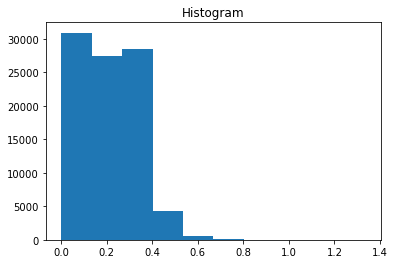

In [22]:
(Arctic_dasiVOluREFmean/1e9).plot.hist()

(array([2.0000e+00, 3.0000e+00, 6.0000e+00, 2.2000e+01, 2.4370e+03,
        6.2479e+04, 2.6366e+04, 3.8100e+02, 9.0000e+00, 2.0000e+00]),
 array([-0.03923067, -0.03262608, -0.0260215 , -0.01941691, -0.01281232,
        -0.00620773,  0.00039686,  0.00700144,  0.01360603,  0.02021062,
         0.02681521]),
 <BarContainer object of 10 artists>)

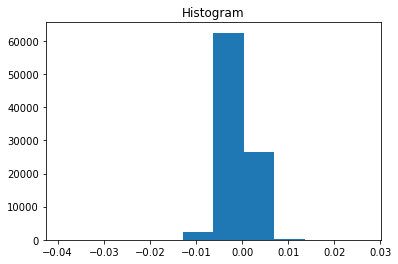

In [26]:
diffGAI_S_mean.plot.hist()

Seaicevolume_mean_diff1m_GAI-AI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


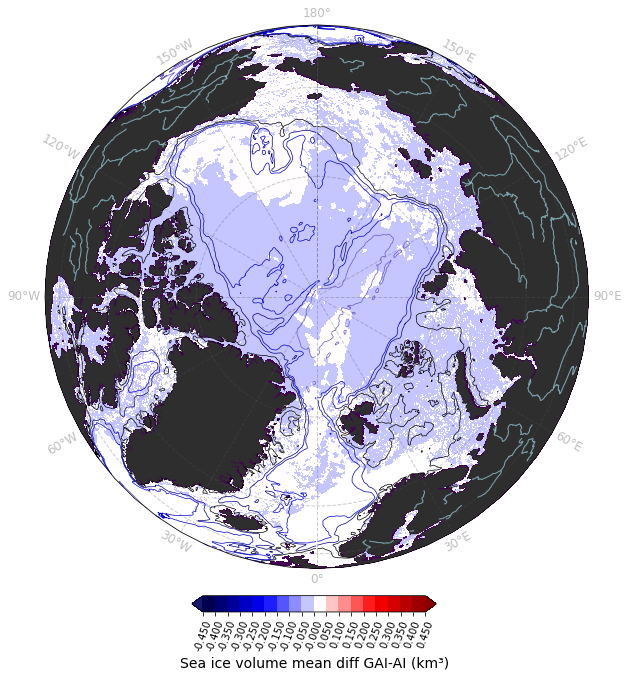

Seaicevolume_mean_1m_GAI-S.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


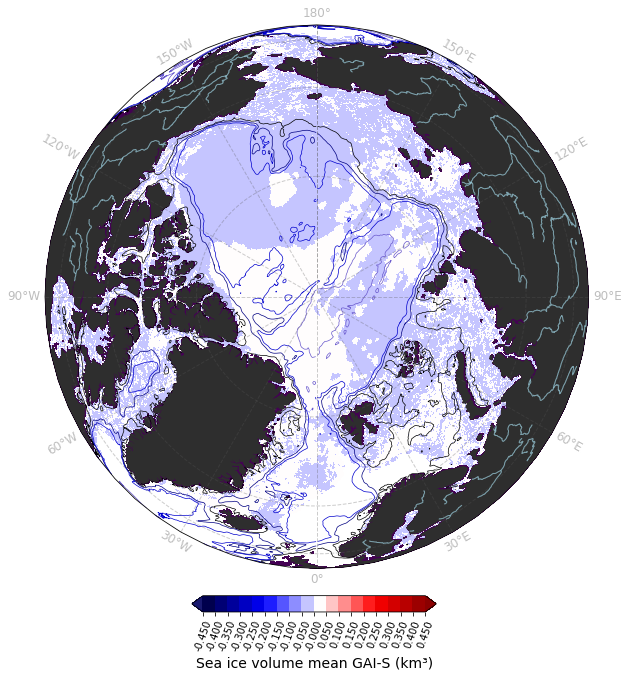

Seaicevolume_mean_1m_AI-S.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


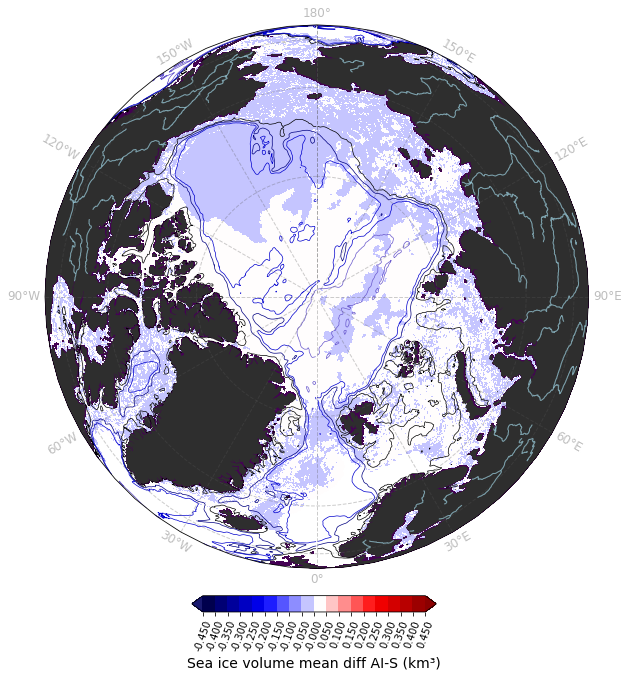

In [15]:
# Map to see sea ice volume MEAN  in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['DIFFGAIAI', 'DIFFGAIS','DIFFAIS']:

    # main variable
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREFmean/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpREF+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpREF+".png"
    
    if iexp=='DIFFGAIAI':
        data = diffGAI_AI_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean diff "+nexpREF+"-"+nexpAI+" (km³)"
        namo = "Seaicevolume_mean_diff"+fo+"_"+nexpREF+"-"+nexpAI+".png"

    if iexp=='DIFFGAIS':
        data = diffGAI_S_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpREF+"-"+nexp+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpREF+"-"+nexp+".png"

    if iexp=='DIFFAIS':
        data = diffAI_S_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean diff "+nexpAI+"-"+nexp+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpAI+"-"+nexp+".png"
    
    if iexp=='nexpAI':
        data = Arctic_dasiVOluAIstd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexpAI+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpAI+".png"
        
    if iexp=='nexp':
        data = Arctic_dasiVOlustd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexp+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexp+".png"
        
    print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[-0.45,0.5,0.05] 

    # COLORMAP
    co='coolwarm' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.3f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

Seaicevolume_mean_1m_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


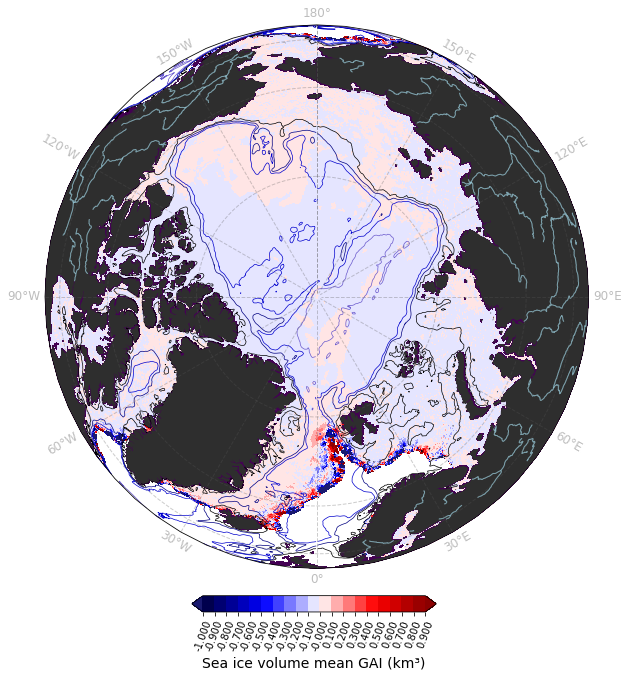

In [22]:
# Map to see sea ice volume MEAN  in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['DIFFGAIAIperc']: #'DIFFGAIAI', 'DIFFGAIS','DIFFAIS']:

    # main variable
    if iexp=='DIFFGAIAIperc':
        data = diffGAI_AI_mean/(Arctic_dasiVOluREFmean/1e9) 
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpREF+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpREF+".png"
    
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREFmean/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpREF+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpREF+".png"
    
    if iexp=='DIFFGAIAI':
        data = diffGAI_AI_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean diff "+nexpREF+"-"+nexpAI+" (km³)"
        namo = "Seaicevolume_mean_diff"+fo+"_"+nexpREF+"-"+nexpAI+".png"

    if iexp=='DIFFGAIS':
        data = diffGAI_S_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpREF+"-"+nexp+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpREF+"-"+nexp+".png"

    if iexp=='DIFFAIS':
        data = diffAI_S_mean
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean diff "+nexpAI+"-"+nexp+" (km³)"
        namo = "Seaicevolume_mean_"+fo+"_"+nexpAI+"-"+nexp+".png"
    
    if iexp=='nexpAI':
        data = Arctic_dasiVOluAIstd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexpAI+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpAI+".png"
        
    if iexp=='nexp':
        data = Arctic_dasiVOlustd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexp+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexp+".png"
        
    print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[-1,1,0.1] 

    # COLORMAP
    co='coolwarm' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.3f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

# calculating the std

In [16]:
Arctic_dasiVOluREFstd = Arctic_dasiVOluREF.std('time_counter')
Arctic_dasiVOluAIstd = Arctic_dasiVOluAI.std('time_counter')
Arctic_dasiVOlustd = Arctic_dasiVOlu.std('time_counter')

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(array([1.0144e+04, 5.1359e+04, 2.0927e+04, 6.0660e+03, 2.2040e+03,
        6.6200e+02, 2.2100e+02, 1.7800e+02, 3.6000e+01, 1.1000e+01]),
 array([0.        , 0.04584774, 0.09169548, 0.13754321, 0.18339095,
        0.22923869, 0.27508643, 0.32093416, 0.3667819 , 0.41262964,
        0.45847738]),
 <BarContainer object of 10 artists>)

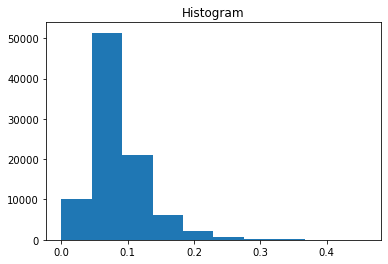

In [85]:
(Arctic_dasiVOluREFstd/1e9).plot.hist()

(array([9.0000e+00, 2.7000e+01, 1.1000e+02, 6.6540e+03, 8.4467e+04,
        4.0000e+02, 3.1000e+01, 5.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-0.02811079, -0.0215083 , -0.0149058 , -0.00830331, -0.00170081,
         0.00490168,  0.01150418,  0.01810667,  0.02470917,  0.03131166,
         0.03791416]),
 <BarContainer object of 10 artists>)

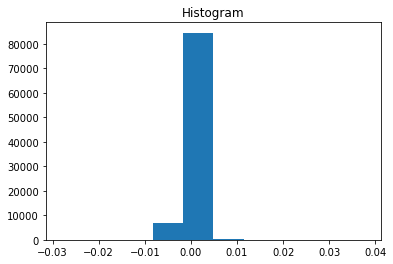

In [86]:
((Arctic_dasiVOluREFstd - Arctic_dasiVOlustd)/1e9).plot.hist()

Seaicevolume_std_diff1m_GAI-AI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


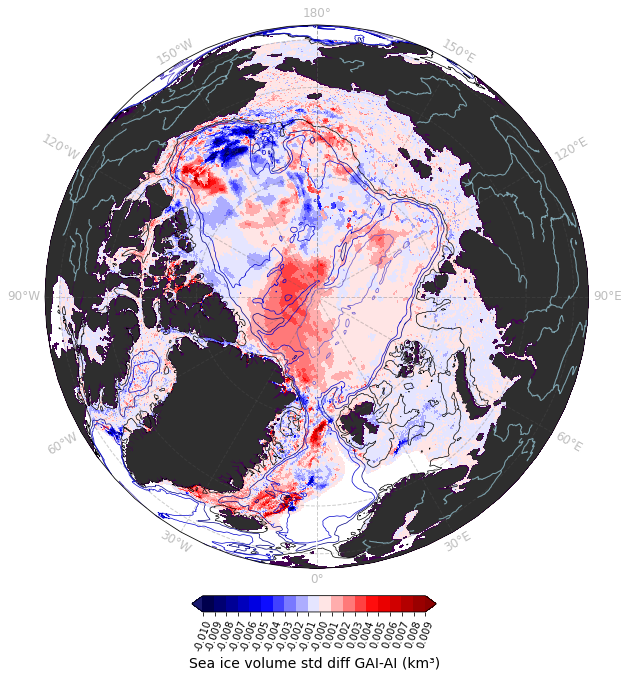

Seaicevolume_std_1m_GAI-S.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


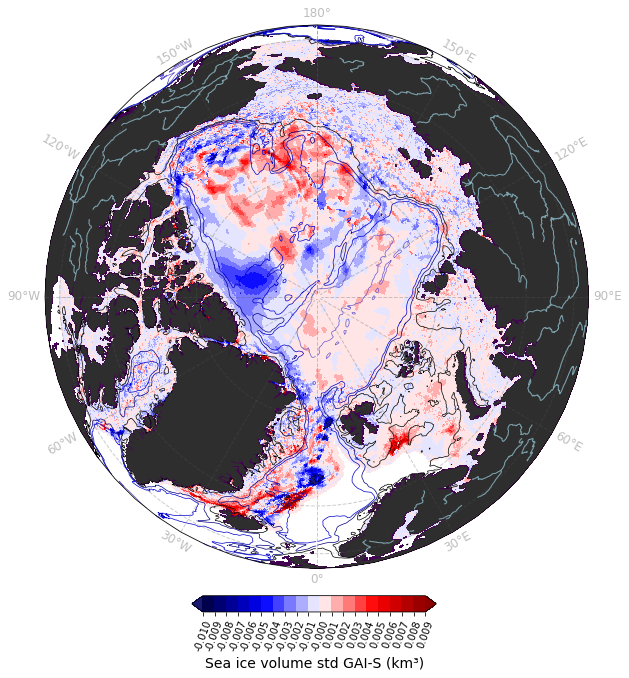

Seaicevolume_std_1m_AI-S.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


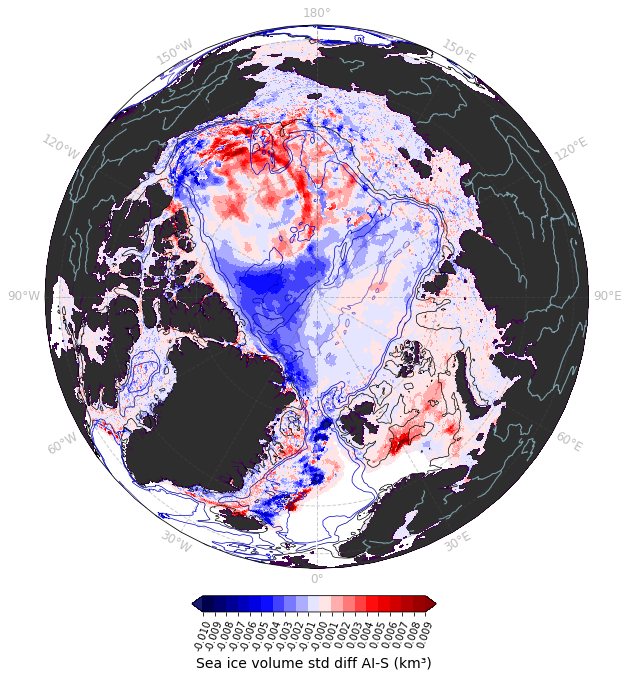

In [19]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['DIFFGAIAI', 'DIFFGAIS','DIFFAIS']:

    # main variable
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREFstd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexpREF+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpREF+".png"
    
    if iexp=='DIFFGAIAI':
        data = (Arctic_dasiVOluREFstd - Arctic_dasiVOluAIstd) /1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std diff "+nexpREF+"-"+nexpAI+" (km³)"
        namo = "Seaicevolume_std_diff"+fo+"_"+nexpREF+"-"+nexpAI+".png"

    if iexp=='DIFFGAIS':
        data = (Arctic_dasiVOluREFstd - Arctic_dasiVOlustd)/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexpREF+"-"+nexp+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpREF+"-"+nexp+".png"

    if iexp=='DIFFAIS':
        data = (Arctic_dasiVOluAIstd - Arctic_dasiVOlustd)/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std diff "+nexpAI+"-"+nexp+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpAI+"-"+nexp+".png"
    
    if iexp=='nexpAI':
        data = Arctic_dasiVOluAIstd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexpAI+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexpAI+".png"
        
    if iexp=='nexp':
        data = Arctic_dasiVOlustd/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume std "+nexp+" (km³)"
        namo = "Seaicevolume_std_"+fo+"_"+nexp+".png"
        
    print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[-0.01,0.01,0.001] 

    # COLORMAP
    co='coolwarm' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.3f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

In [18]:
Arctic_dasiVOluREF.sel(time_counter='2001-06')

<xarray.DataArray (time_counter: 1)>
array([2.41635024e+13])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2001-06-30

Seaicevolume_200106_1m_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


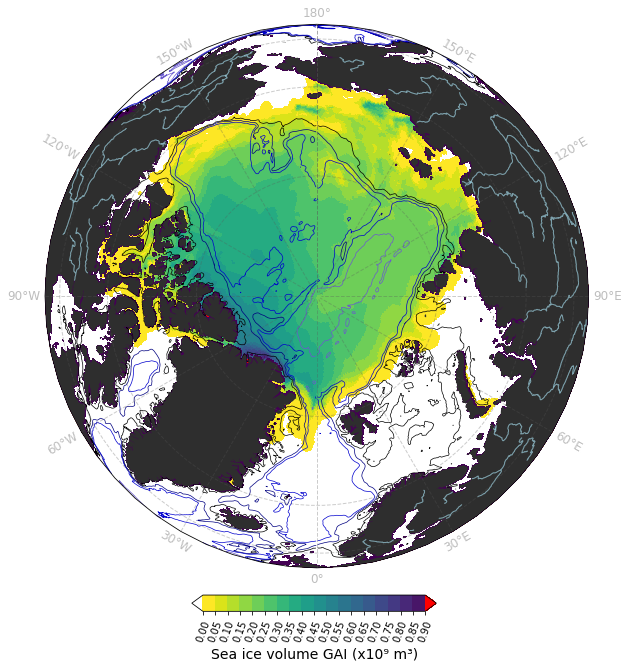

In [21]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREF.sel(time_counter='2001-09')/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume "+nexpREF+" (x10⁹ m³)" #" over "+y1+"-"+y2 # SSH
        namo = "Seaicevolume_200106_"+fo+"_"+nexpREF+".png"
        print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[0,0.95,0.05]  # varna sossheig

    # COLORMAP
    co='vi' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.2f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

# in the boxBG

In [15]:
BGdasiVOlu = dasiVOlu.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))
BGdasiVOluREF = dasiVOluREF.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))
BGdasiVOluAI = dasiVOluAI.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))

BGdasiVOluGA = dasiVOluGA.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))
BGdasiVOluGI = dasiVOluGI.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))

In [47]:
#calcul de la climatology for each month
BGsiVOlu_clim = BGdasiVOlu.groupby('time_counter.month').mean()

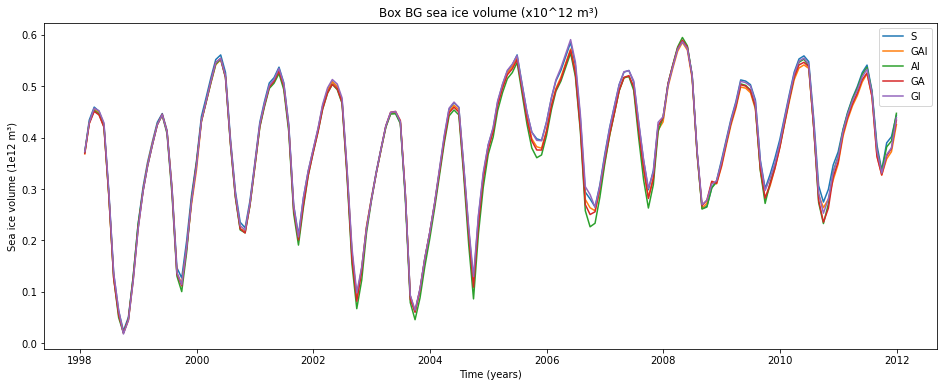

from monthly data


In [16]:
# time series of sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,BGdasiVOlu/1e12)
plt.plot(time,BGdasiVOluREF/1e12)
plt.plot(time,BGdasiVOluAI/1e12)
plt.plot(time,BGdasiVOluGA/1e12)
plt.plot(time,BGdasiVOluGI/1e12)

#plt.plot(time,np.tile(BGsiVOlu_clim/1e12,14))
plt.legend(['S','GAI','AI','GA','GI'])
plt.title('Box BG sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from monthly data")

In [56]:
print('mean (box BG)',BGdasiVOluREF.mean().values/1e12,'10³ km³')

mean (box BG) 0.376929818035707 10³ km³


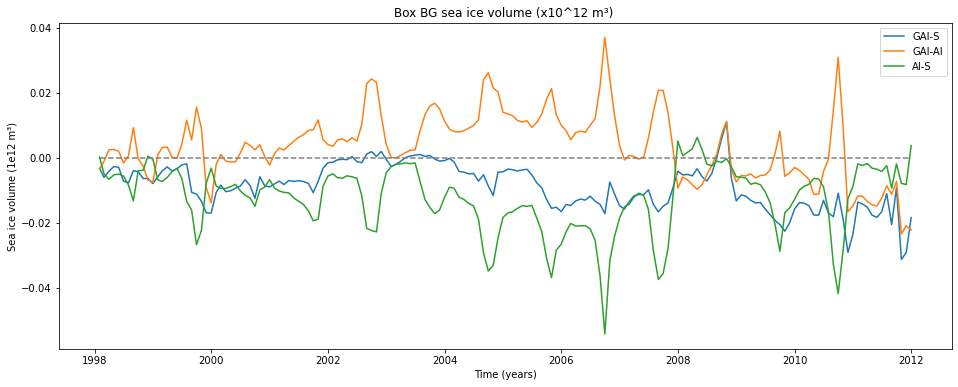

from annual data


In [54]:
# time series of totla Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,BGdasiVOluREF/1e12 - BGdasiVOlu/1e12)
plt.plot(time,BGdasiVOluREF/1e12 - BGdasiVOluAI/1e12)
plt.plot(time,BGdasiVOluAI/1e12 - BGdasiVOlu/1e12)

plt.plot(time,np.zeros(168),linestyle='--', color='grey',)
#plt.plot(time,np.tile(BGsiVOlu_clim/1e11,14))
plt.legend(['GAI-S','GAI-AI','AI-S'])
plt.title('Box BG sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from annual data")

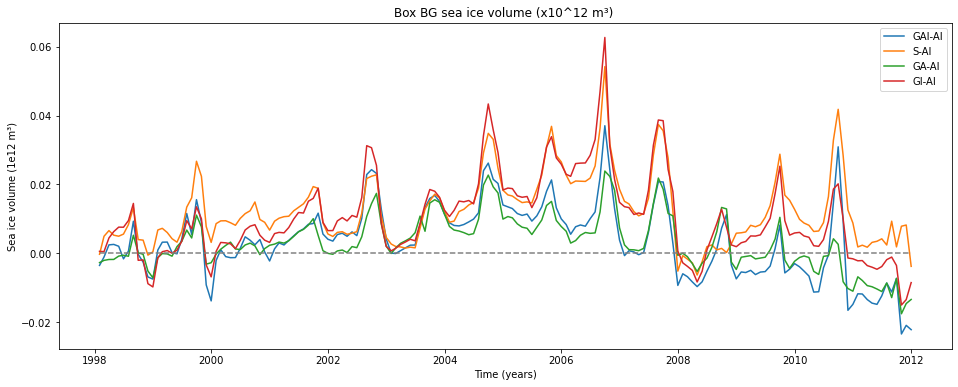

from annual data


In [17]:
# time series of totla Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
#plt.plot(time,BGdasiVOluREF/1e12 - BGdasiVOlu/1e12)
plt.plot(time,BGdasiVOluREF/1e12 - BGdasiVOluAI/1e12)
plt.plot(time,BGdasiVOlu/1e12 - BGdasiVOluAI/1e12)
plt.plot(time,BGdasiVOluGA/1e12 - BGdasiVOluAI/1e12)
plt.plot(time,BGdasiVOluGI/1e12 - BGdasiVOluAI/1e12)

plt.plot(time,np.zeros(168),linestyle='--', color='grey',)
#plt.plot(time,np.tile(BGsiVOlu_clim/1e11,14))
plt.legend(['GAI-AI','S-AI','GA-AI','GI-AI'])
plt.title('Box BG sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from annual data")

In [16]:
x = (BGdasiVOluREF/1e12 - BGdasiVOluAI/1e12).mean()
y = BGdasiVOluREF.mean().values/1e12
(x/y)*100

<xarray.DataArray ()>
array(0.95603798)

In [58]:
print('proportion of différence between runs',(0.054/0.376)*100, "%")

proportion of différence between runs 14.361702127659573 %


## map of the sea ice volume per month in the box

In [36]:
BGdasiVOluREF = dasiVOluREF.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True)
climBGdasiVOluREF = BGdasiVOluREF.groupby('time_counter.month').mean()

<Figure size 432x288 with 0 Axes>

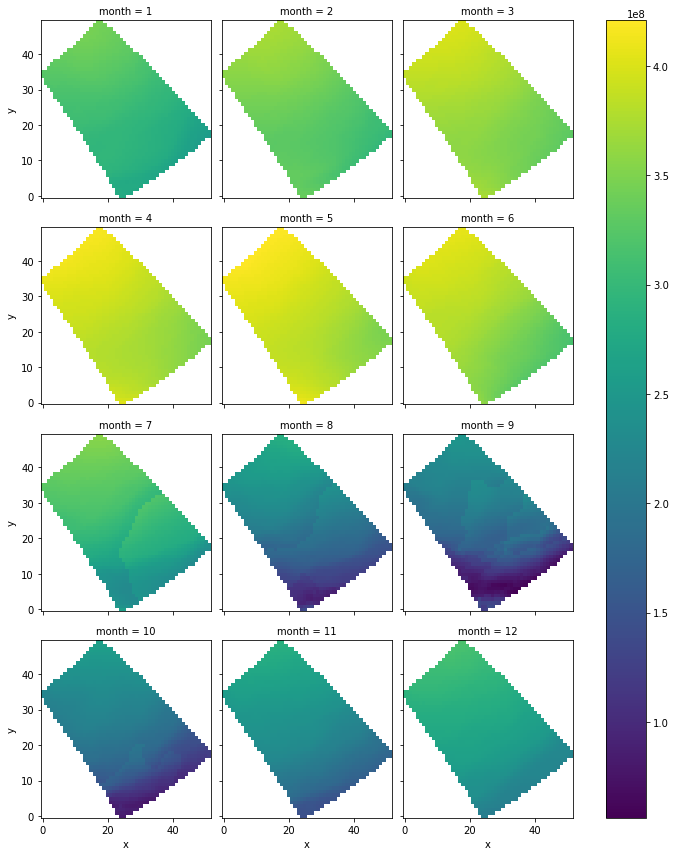

In [37]:
plt.figure(facecolor='white')

g_simple = climBGdasiVOluREF.plot( col="month", col_wrap=3)

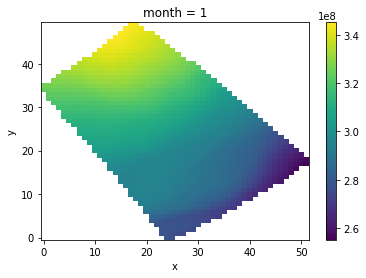

In [38]:
climBGdasiVOluREF.isel(month=0).plot()